# 5.3.3 Isotropic Model Results in the Time Domain

Numerical examples of the book  

### Introduction to Controlled-Source Electromagnetic Methods  
Anton Ziolkowski and Evert Slob, 2019, *Cambridge University Press*; ISBN: [9781107058620](https://www.cambridge.org/9781107058620).

- - -
Copyright 2018 Dieter Werthmüller

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0). Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [1]:
import numpy as np
import empymod as epm
import matplotlib.pyplot as plt

%matplotlib inline

### Choose your preferred colour map

The book shows in the chapter black-and-white figures, and in the plate section coloured versions.

In [2]:
plt.rcParams['image.cmap'] = 'viridis'  # Colour
# plt.rcParams['image.cmap'] = 'gray'   # Black-and-white

## Calculation

### General model parameters

In [3]:
# Offsets for deep sea model
x = np.linspace(0, 1e4, 121)
x[0] = 10  # Min offset set to 10 m

# Times
t = np.logspace(-2, 2, 101)

# Resistivity models
rtg = [2e14, 1/3, 1, 70, 1]  # With target
rhs = [2e14, 1/3, 1, 1, 1]   # Half-space

# Common model parameters (deep sea parameters)
model = {'src': [0, 0, 975],               # Source location
         'rec': [x, x*0, 1000],            # Receiver location
         'depth': [0, 1000, 2000, 2040],   # Depths
         'freqtime': t,                    # Frequencies
         'signal': 0,                      # Impulse response
         'htarg': 'key_201_2012',          # Use same filter as in book
         # 'htarg': ['key_201_2012', -1],  # Use lagged conv. Much faster.
         'ft': 'sin',                      # Sine-Fourier
         'ftarg': 'key_SinCos_201_2012',   # Use same filter as in book
         'verb': 1}                        # Verbosity

### Calculate deep sea model

- water depth of 1000 m
- source depth 975 m
- receiver depth 1000 m

In [4]:
# With reservoir
target = epm.dipole(res=rtg, **model)

# Without reservoir
notarg = epm.dipole(res=rhs, **model)

### Calculate shallow model; deep src/rec

- water depth of 100 m
- source depth 75 m
- receiver depth 100 m

In [5]:
# Depths
model['depth'] = [0, 100, 1100, 1140]

# Offsets for shallow model
xs = np.linspace(0, 1.5e4, 181)
xs[0] = 10  # Min offset set to 10 m

# Deep source, receiver on sea bottom
model['src'][2] = 75
model['rec'] = [xs, xs*0, 100]

# With reservoir
sdtarget = epm.dipole(res=rtg, **model)

# Without reservoir
sdnotarg = epm.dipole(res=rhs, **model)

### Calculate shallow model; shallow src/rec

- water depth of 100 m
- source depth 10 m
- receiver depth 50 m

In [6]:
# Shallow source and streamer
model['src'][2] = 10
model['rec'][2] = 50

# With reservoir
sstarget = epm.dipole(res=rtg, **model)

# Without reservoir
ssnotarg = epm.dipole(res=rhs, **model)

### Create and add noise to data

In [7]:
# Create noise for deep water example
mask = 1e-2*(1.5 - np.random.random_sample(target.shape))
mask0 = 1e-2*(1.5 - np.random.random_sample(target.shape))
maskn = 1e-15*(1.5 - np.random.random_sample(target.shape))
maskn0 = 1e-15*(1.5 - np.random.random_sample(target.shape))

# Add noise to target and notarg results
targetn = target*(1 + mask) + maskn
notargn = notarg*(1 + mask0) + maskn0

# Create noise for shallow water example
mask2 = 1e-2*(1.5 - np.random.random_sample(sstarget.shape))
mask02 = 1e-2*(1.5 - np.random.random_sample(sstarget.shape))
maskn2 = 1e-15*(1.5 - np.random.random_sample(sstarget.shape))
maskn02 = 1e-15*(1.5 - np.random.random_sample(sstarget.shape))

# Add noise to shallow model, deep source
sdtargetn = sdtarget*(1 + mask2) + maskn2
sdnotargn = sdnotarg*(1 + mask02) + maskn02

# Add noise to shallow model, shallow source
sstargetn = sstarget*(1 + mask2) + maskn2
ssnotargn = ssnotarg*(1 + mask02) + maskn02

### Plotting function

In [8]:
def plot_result(data, px, error=False):
    """Create figure.
    
    All figures in this section are almost identical, just differ in
    the shown data. We can therefore define a plot-function which
    we subsequently call with the different results.
    
    """
    n = int(len(data)/2)
    
    # Define figure size depending if 2 or 4 data-sets.
    if n == 2:
        size = (10, 9)
        pad = 0.1
    else:
        size = (10, 4.5)
        pad = 0.2
        
    if error:
        clbticks = [-2, -1, 0, 1, 2]
        vmin = -2
        vmax = 2
        levels = np.linspace(-2, 2, 100)
    else:
        clbticks = [-16, -14, -12, -10, -8]
        vmin = -16
        vmax = -8
        levels = np.linspace(-16, -8, 100)

    # Start figure
    fig, axs = plt.subplots(figsize=size, nrows=n, ncols=2)
    axs = axs.ravel()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    # Loop over data
    for i, val in enumerate(data):
        plt.sca(axs[i])
        
        # pcolormesh takes x/y as start and end point of pixels,
        # not midpoints. So we have to create these.
        dx = (px[1]-px[0])/2
        ppx = np.r_[px-dx, px[-1]+dx]/1000
        lt = np.log10(t)
        dt = (lt[1]-lt[0])/2
        pt = 10**(np.r_[lt-dt, lt[-1]+dt])
        
        # Plot result
        cs = plt.pcolormesh(ppx, pt, np.nan_to_num(np.log10(np.abs(val))),
                            vmin=vmin, vmax=vmax)
        
        # Plot contours at every decade
        cs2 = plt.contour(px/1000, t, np.log10(np.abs(val)),
                          levels=np.arange(vmin, vmax+1),
                          linewidths=0.5, colors=[(0, 0, 0, 0.5)])

        if px[-1] > 11000:
            plt.xticks([0, 5, 10, 15])
        else:
            plt.xticks([0, 2, 4, 6, 8, 10])
        plt.xlabel('Offset (km)')
        plt.ylabel('$\log_{10}(t)$ (s)')
        axs[i].set_yscale('log')
        axs[i].invert_yaxis()
        plt.yticks([1e2, 1e1, 1e0, 1e-1, 1e-2], ('2', '1', '0', '-1', '-2'))

    # Plot colorbar
    cax, kw = plt.matplotlib.colorbar.make_axes(axs, location='bottom',
                                                fraction=.05, pad=pad, aspect=30)
    cb = plt.colorbar(cs, cax=cax, ticks=clbticks, **kw)

    plt.show()
    

def thin_y_ticks():
    """Hide every second y-tick label."""
    for label in plt.gca().get_yticklabels()[::2]:
        label.set_visible(False)

## Figure 5.29

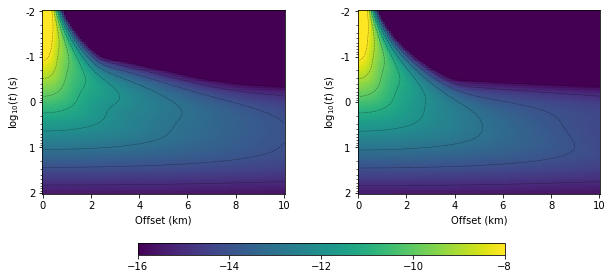

In [9]:
plot_result([target, notarg], x)

Figure 5.29 Electric field impulse response as a function of offset for the deep sea model with (left) and without (right) a 40 m thick buried resistive layer 1000 m below the sea floor. The colour bar indicates the amplitudes in logarithmic scale.

## Figure 5.30

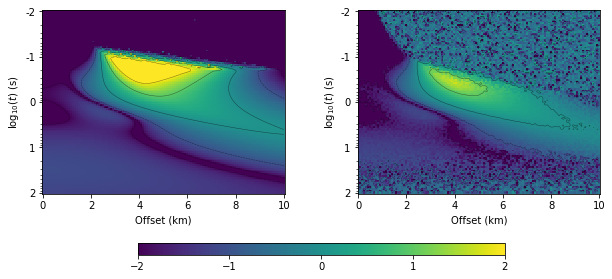

In [10]:
plot_result([(target-notarg)/notarg, (targetn-notargn)/notargn], x, True)

Figure 5.30 Electric field impulse response difference between models with and without resistive layer shown in Figure 5.29 as a function of offset for the deep sea model for noise-free (left) and noise (right) models. The colour bar indicates the normalised difference in logarithmic scale.

## Figure 5.31

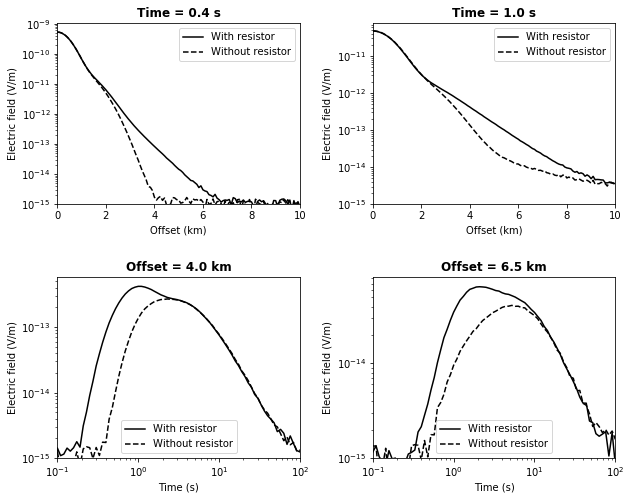

In [11]:
# Define indeces
nt1, nt2 = 40, 50  # Time
nx1, nx2 = 48, 78  # Offset

# Figure
plt.figure(figsize=(10, 8))
plt.subplots_adjust(wspace=.3, hspace=.4)

# 1st subplot
plt.subplot(221)
plt.title('Time = '+str(np.round(t[nt1], 1))+' s', fontweight='bold')
plt.semilogy(x/1000, targetn[nt1, :], 'k-', label='With resistor')
plt.semilogy(x/1000, notargn[nt1, :], 'k--', label='Without resistor')
plt.xlabel('Offset (km)')
plt.ylabel('Electric field (V/m)')
plt.xlim([0, 10])
plt.ylim([1e-15, plt.gca().get_ylim()[1]])
plt.legend()

# 2nd subplot
plt.subplot(222)
plt.title('Time = '+str(np.round(t[nt2], 1))+' s', fontweight='bold')
plt.semilogy(x/1000, targetn[nt2, :], 'k-', label='With resistor')
plt.semilogy(x/1000, notargn[nt2, :], 'k--', label='Without resistor')
plt.xlabel('Offset (km)')
plt.ylabel('Electric field (V/m)')
plt.xlim([0, 10])
plt.ylim([1e-15, plt.gca().get_ylim()[1]])
plt.legend()

# 3rd subplot
plt.subplot(223)
plt.title('Offset = '+str(np.round(x[nx1]/1000, 1))+' km', fontweight='bold')
plt.loglog(t, targetn[:, nx1], 'k-', label='With resistor')
plt.loglog(t, notargn[:, nx1], 'k--', label='Without resistor')
plt.xlabel('Time (s)')
plt.ylabel('Electric field (V/m)')
plt.xlim([0.1, 100])
plt.ylim([1e-15, plt.gca().get_ylim()[1]])
plt.legend()

# 4th subplot
plt.subplot(224)
plt.title('Offset = '+str(np.round(x[nx2]/1000, 1))+' km', fontweight='bold')
plt.loglog(t, targetn[:, nx2], 'k-', label='With resistor')
plt.loglog(t, notargn[:, nx2], 'k--', label='Without resistor')
plt.xlabel('Time (s)')
plt.ylabel('Electric field (V/m)')
plt.xlim([0.1, 100])
plt.ylim([1e-15, plt.gca().get_ylim()[1]])
plt.legend()

plt.show()

Figure 5.31 Electric field impulse response for the deep sea model without (solid lines) and with (dashed lines) as a function of offset (top) at 0.4 s (left) and 1 s (right) and as a function of time (bottom) at 4 km and 6.5 km offsets.

## Figure 5.32

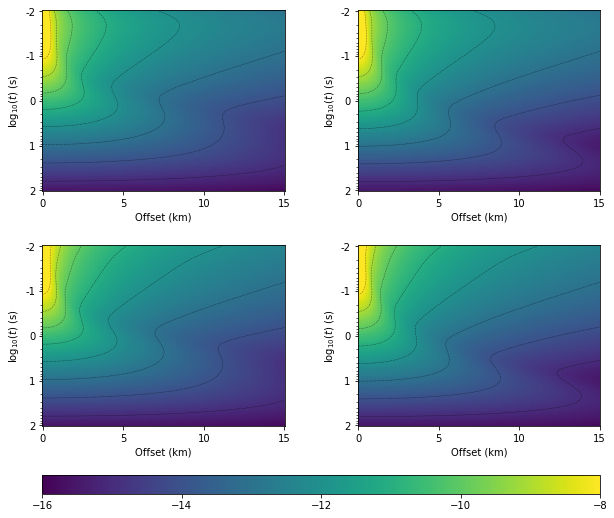

In [12]:
plot_result([sdtarget, sdnotarg, sstarget, ssnotarg], xs)

Figure 5.32 Electric field impulse response as a function of offset for the shallow sea model with (left) and without (right) a 40 m thick buried resistive layer 1000 m below the sea floor for sea-floor receivers (top) and streamer receivers (bottom).

## Figure 5.33

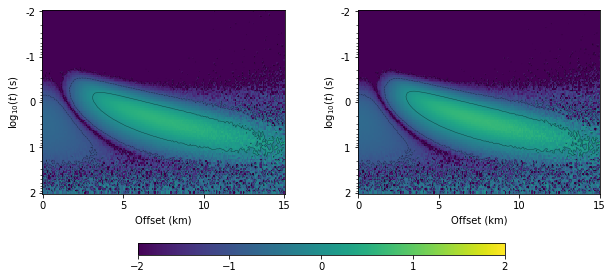

In [13]:
plot_result([(sdtargetn-sdnotargn)/sdnotargn, (sstargetn-ssnotargn)/ssnotargn], xs, True)

Figure 5.33 Electric field impulse response difference between models with and without the resistive layer, as shown in Figure 5.29, but using the noise model, as a function of offset for the shallow sea model for sea-floor data (left) and streamer data (right). The colour bar indicates the normalised difference in logarithmic scale.

## Figure 5.34

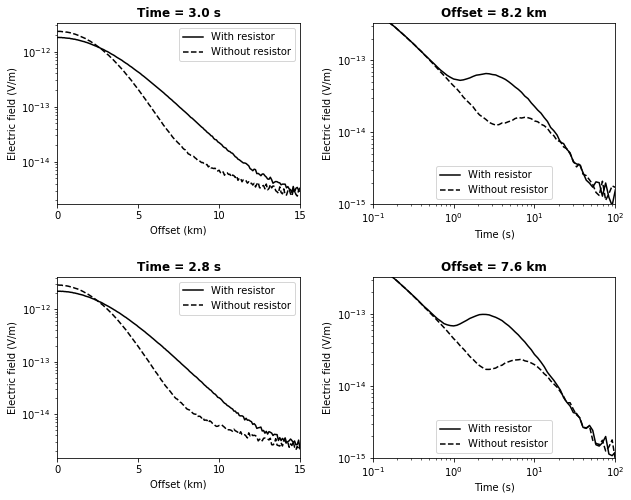

In [14]:
# Indeces
nt1, nt2 = 62, 61  # Times
nx1, nx2 = 99, 91  # Offsets

# Figure
plt.figure(figsize=(10, 8))
plt.subplots_adjust(wspace=.3, hspace=.4)

# 1st subplot
plt.subplot(221)
plt.title('Time = '+str(np.round(t[nt1], 1))+' s', fontweight='bold')
plt.semilogy(xs/1000, sdtargetn[nt1, :], 'k-', label='With resistor')
plt.semilogy(xs/1000, sdnotargn[nt1, :], 'k--', label='Without resistor')
plt.xlabel('Offset (km)')
plt.ylabel('Electric field (V/m)')
plt.xlim([0, 15])
plt.xticks([0, 5, 10, 15])
plt.legend()

# 2nd subplot
plt.subplot(223)
plt.title('Time = '+str(np.round(t[nt2], 1))+' s', fontweight='bold')
plt.semilogy(xs/1000, sstargetn[nt2, :], 'k-', label='With resistor')
plt.semilogy(xs/1000, ssnotargn[nt2, :], 'k--', label='Without resistor')
plt.xlabel('Offset (km)')
plt.ylabel('Electric field (V/m)')
plt.xlim([0, 15])
plt.xticks([0, 5, 10, 15])
plt.legend()

# 3rd subplot
plt.subplot(222)
plt.title('Offset = '+str(np.round(xs[nx1]/1000, 1))+' km', fontweight='bold')
plt.loglog(t, sdtargetn[:, nx1], 'k-', label='With resistor')
plt.loglog(t, sdnotargn[:, nx1], 'k--', label='Without resistor')
plt.xlabel('Time (s)')
plt.ylabel('Electric field (V/m)')
plt.xlim([0.1, 100])
plt.ylim([1e-15, 3.3e-13])
plt.legend(loc=8)

# 4th subplot
plt.subplot(224)
plt.title('Offset = '+str(np.round(xs[nx2]/1000, 1))+' km', fontweight='bold')
plt.loglog(t, sstargetn[:, nx2], 'k-', label='With resistor')
plt.loglog(t, ssnotargn[:, nx2], 'k--', label='Without resistor')
plt.xlabel('Time (s)')
plt.ylabel('Electric field (V/m)')
plt.xlim([0.1, 100])
plt.ylim([1e-15, 3.3e-13])
plt.legend(loc=8)

plt.show()

Figure 5.34 Electric field impulse response for the shallow sea model with (solid lines) and without (dashed lines) the buried resistive layer for the sea-floor data (top) and streamer data (bottom) as a function of offset at the time of the maximum difference (left) as a function of time at the offset of the maximum difference (right).

In [15]:
epm.versions('HTML')